# Explore the relationship between hospitalization duration and diagnosis codes

In [2]:
import sys
sys.path.append("/home/wanxinli/deep_patient/")

from ast import literal_eval
from common import *
from mimic_common import *
from multiprocess import Pool
import os
import random
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import time


/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/mimic")
print(f"Will save outputs to {output_dir}")

Will save outputs to /home/wanxinli/deep_patient/outputs/mimic


In [3]:
""" 
Read in the original dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
print(admid_diagnosis_df)

""" 
Print number of patients for each category
"""
print("female:", admid_diagnosis_df.loc[(admid_diagnosis_df['gender'] == 'F')].shape[0])
print("male:", admid_diagnosis_df.loc[(admid_diagnosis_df['gender'] == 'M')].shape[0])


         adm_type gender                                          ICD codes  \
admid                                                                         
172335  EMERGENCY      F  [403.01, 486, 582.81, 585.5, 425.4, 276.2, 710...   
173633  EMERGENCY      F  [403.01, 585.6, 583.81, 710.0, 558.9, 287.5, 2...   
174105  EMERGENCY      M               [531.00, 410.71, 285.9, 414.01, 725]   
109976  EMERGENCY      M                             [191.5, 331.4, 530.81]   
178393   ELECTIVE      M       [414.01, 411.1, 482.83, 285.9, 272.0, 305.1]   
...           ...    ...                                                ...   
172304   ELECTIVE      F       [202.80, 348.5, 784.3, 401.9, 272.0, 530.81]   
152542  EMERGENCY      M  [566, 250.62, 357.2, V58.67, 427.31, 401.9, 42...   
161999  EMERGENCY      M  [434.11, 348.5, 348.4, 430, 348.30, 997.31, 51...   
189314  EMERGENCY      F  [346.80, 784.3, 745.5, 781.94, 368.40, 781.3, ...   
168949  EMERGENCY      M  [052.9, 416.2, 201.92, 135

In [4]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var[-1])
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var[-1])

    return target_reps, source_reps

In [5]:
n_components = 25
model_func = linear_model.LinearRegression
entire_proc_cts(n_components, admid_diagnosis_df, custom_train_reps, model_func, male_count = 120, female_count = 100, pca_explain=True)

Cummulative variance explained by the source PCA is: 0.5395502186251998
Cummulative variance explained by the target PCA is: 0.5571531881991004


(496697.1965500995,
 819896.6511686179,
 706875.1385954972,
 1178970.8108184843,
 674947.2427539165,
 1041707.3082815842)

Run one iteration using Linear regression

Study the admission map

In [6]:

""" 
Obtain the female count by male count coupling
"""

# model_func = linear_model.LinearRegression
model_func=  linear_model.PoissonRegressor
male_count = 60
female_count = 50
selected_df = select_df_cts(admid_diagnosis_df, male_count=male_count, female_count=female_count)
selected_df = selected_df.drop(columns=['adm_type', 'diagnosis', 'label'])
selected_df_male = selected_df[selected_df['gender']=='M']
selected_df_female = selected_df[selected_df['gender']=='F']
selected_df_male.to_csv(os.path.join(output_dir, "selected_df_male.csv"), header=True, index=True)
selected_df_female.to_csv(os.path.join(output_dir, "selected_df_female.csv"), header=True, index=True)

source_features, source_labels, target_features, target_labels = gen_features_duration(selected_df)

target_reps, source_reps = custom_train_reps(target_features, source_features, n_components)
np.savetxt(os.path.join(output_dir, "target_reps.txt"), target_reps)
np.savetxt(os.path.join(output_dir, "source_reps.txt"), source_reps)


ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=100000)
ot_sinkhorn.fit(Xs=target_reps, Xt=source_reps)
trans_target_reps = ot_sinkhorn.transform(Xs=target_reps)




In [7]:
def calc_stats(source_reps, source_labels, target_reps, target_labels, \
    trans_target_reps, model_func): 
    # fit the model
    source_model = model_func()
    source_model.fit(source_reps, source_labels)

    # calculate the stats
    source_pred_labels = source_model.predict(source_reps)
    # source_mae = [metrics.mean_absolute_error(i, j) for i, j in zip(source_labels, source_pred_labels)]
    # source_mse = metrics.mean_squared_error(source_labels, source_pred_labels)
    # source_rmse = np.sqrt(metrics.mean_squared_error(source_labels, source_pred_labels))

    target_pred_labels = source_model.predict(target_reps)
    target_mae = [abs(i-j) for i, j in zip(target_labels, target_pred_labels)]
    # target_mse = metrics.mean_squared_error(target_labels, target_pred_labels)
    # target_rmse = np.sqrt(metrics.mean_squared_error(target_labels, target_pred_labels))

    trans_target_pred_labels = source_model.predict(trans_target_reps)
    trans_target_mae = [abs(i-j) for i, j in zip(target_labels, trans_target_pred_labels)]
    # trans_target_mse = [metrics.mean_squared_error(i, j) for i, j in zip(target_labels, trans_target_pred_labels)]
    # trans_target_rmse =  [np.sqrt(metrics.mean_squared_error(i, j)) for i, j in zip(target_labels, trans_target_pred_labels)]
    return target_mae, trans_target_mae

In [8]:
target_maes, trans_target_maes = calc_stats(source_reps, source_labels, target_reps, target_labels, \
    trans_target_reps, linear_model.LinearRegression)

print(trans_target_reps.shape)
selected_df_female['target_ae'] = target_maes
selected_df_female['trans_target_ae'] = trans_target_maes
selected_df_female['ae_ratio'] = [(i-j)/j for i, j in zip(trans_target_maes, target_maes)]
selected_df_female

(50, 25)


/tmp/ipykernel_2634775/4153930218.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df_female['target_ae'] = target_maes
/tmp/ipykernel_2634775/4153930218.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df_female['trans_target_ae'] = trans_target_maes
/tmp/ipykernel_2634775/4153930218.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,gender,ICD codes,duration,target_ae,trans_target_ae,ae_ratio
admid,,,,,,
145439,F,"[414.01, 411.1, 135, 517.8, 401.9, 272.0, 285....",687840.0,2.493685e+04,9.723190e+04,2.899125
194220,F,"[562.12, 599.0, 493.20, 276.2, 285.1, 518.83, ...",650040.0,7.257270e+04,5.703897e+05,6.859562
147964,F,"[535.50, 935.1, 428.0, E915, E849.0, 401.9, 24...",352740.0,5.144537e+04,4.094594e+05,6.959111
136471,F,"[V30.00, V29.0, V05.3, 757.33]",156240.0,6.425407e+05,7.314761e+05,0.138412
116141,F,"[V30.00, V29.0, V05.3]",170280.0,6.273185e+05,6.568243e+05,0.047035
164846,F,"[518.81, 427.5, 276.2, 304.21, 348.1, 038.9, 9...",644400.0,3.085650e+05,1.272476e+06,3.123851
153844,F,"[486, 416.2, 428.32, 280.9, 276.52, 427.31, 40...",435000.0,1.318905e+06,1.747885e+06,0.325255
156682,F,"[934.1, 276.2, 428.32, 496, 428.0, 401.9, 715....",437880.0,9.362322e+05,2.204207e+05,-0.764566
157305,F,"[996.81, 590.2, 998.31, 567.2, 997.5, 552.21, ...",6501060.0,6.180909e+06,6.035150e+06,-0.023582


In [9]:
""" 
Study the coupling

Find the most two similar males for each female
"""

max_male_indices = []
max_male_probs = []
for i in range(ot_sinkhorn.coupling_.shape[0]): # for each column
    max_male_indices.append(np.argmax(ot_sinkhorn.coupling_[i, :])+1)
    max_male_probs.append(np.max(ot_sinkhorn.coupling_[i, :]))

print(len(max_male_indices))
print(max_male_indices)
print(max_male_probs)
selected_df_female['max_prob'] = max_male_probs
selected_df_female
selected_df_female.to_csv(os.path.join(output_dir, "selected_df_female.csv"), header=True, index=True)



50
[20, 41, 3, 35, 35, 56, 58, 6, 37, 40, 32, 30, 9, 57, 27, 13, 4, 35, 12, 21, 5, 10, 14, 45, 31, 50, 2, 33, 55, 1, 16, 22, 23, 18, 60, 52, 36, 17, 47, 59, 11, 44, 24, 2, 24, 34, 49, 51, 39, 53]
[0.014810712933502647, 0.016666666834013324, 0.013386536418716568, 0.003565911418788377, 0.0035492082743056952, 0.01666666692671902, 0.016666662818601134, 0.016664320698401125, 0.016586620951326743, 0.010779148953639647, 0.0035275344940362014, 0.010721338160059884, 0.01564663233128821, 0.016666667299269577, 0.01476872024255209, 0.009909041864112251, 0.016666498842588435, 0.0035492082743056102, 0.009298361915861525, 0.016659011870487142, 0.00393175426131099, 0.008300843721817358, 0.012557579142183023, 0.009724790936915943, 0.01063899940890218, 0.016508102008788033, 0.004394056950283654, 0.010313292319411846, 0.0125865388608523, 0.013556602976600008, 0.004564937116948069, 0.013846876053799468, 0.016462472166274836, 0.01666661101924643, 0.016666667127406474, 0.01280992379065661, 0.015878680875748

/tmp/ipykernel_2634775/2993418858.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df_female['max_prob'] = max_male_probs


Text(0, 0.5, 'absolute error increment')

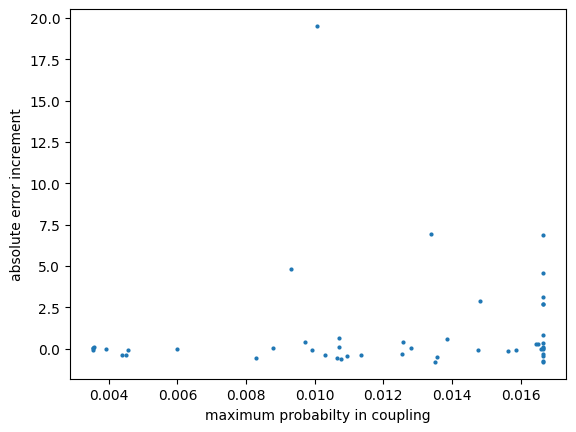

In [10]:
""" 
Plot mae ratio vs max probablity
"""
plt.scatter(list(selected_df_female['max_prob']), list(selected_df_female['ae_ratio']), s=4) 
plt.xlabel('maximum probabilty in coupling')
plt.ylabel('absolute error increment')
# plt.ylim(-2, 0)

/tmp/ipykernel_2634775/4018659793.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = sns.heatmap(heatmap_df.pivot('female_index', 'male_index', 'probability'), cmap="Blues")


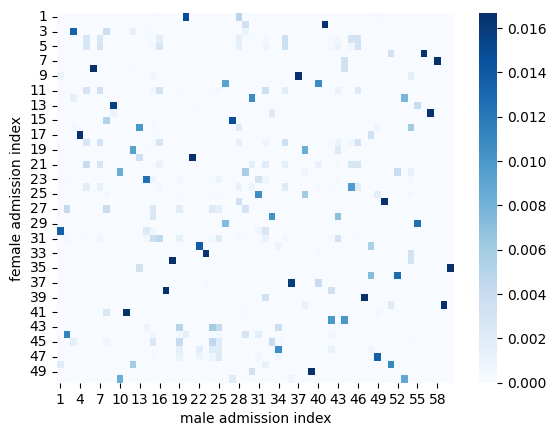

In [11]:
""" 
Match each female with the most likely male by appending the dataframe
"""
selected_df_female = selected_df_female.reset_index(drop=True)
selected_df_male = selected_df_male.reset_index(drop=True)
heatmap_vec = []
thres = 0.002 # only taking the couplings that exceed thres
coupling_thres = np.zeros(shape=ot_sinkhorn.coupling_.shape)
for i in range(ot_sinkhorn.coupling_.shape[0]): # for each column
    # max_male_index = np.argmax(ot_sinkhorn.coupling_[:, i])
    # max_male_prob = np.max(ot_sinkhorn.coupling_[:, i])
    for j in range(ot_sinkhorn.coupling_.shape[1]):
        heatmap_vec.append([i+1, j+1, ot_sinkhorn.coupling_[i][j]])
        if ot_sinkhorn.coupling_[i][j] >= thres:
            coupling_thres[i][j] = ot_sinkhorn.coupling_[i][j]

    # print("count is:", count)
heatmap_df = pd.DataFrame(heatmap_vec, columns=['female_index', 'male_index', 'probability'])

ticksize=10
fig_path = os.path.join(output_dir, "exp4_heatmap.pdf")
ax = sns.heatmap(heatmap_df.pivot('female_index', 'male_index', 'probability'), cmap="Blues")

plt.xlabel("male admission index", fontsize=ticksize)
plt.ylabel("female admission index", fontsize=ticksize)
plt.savefig(fig_path, bbox_inches = 'tight')
plt.show()


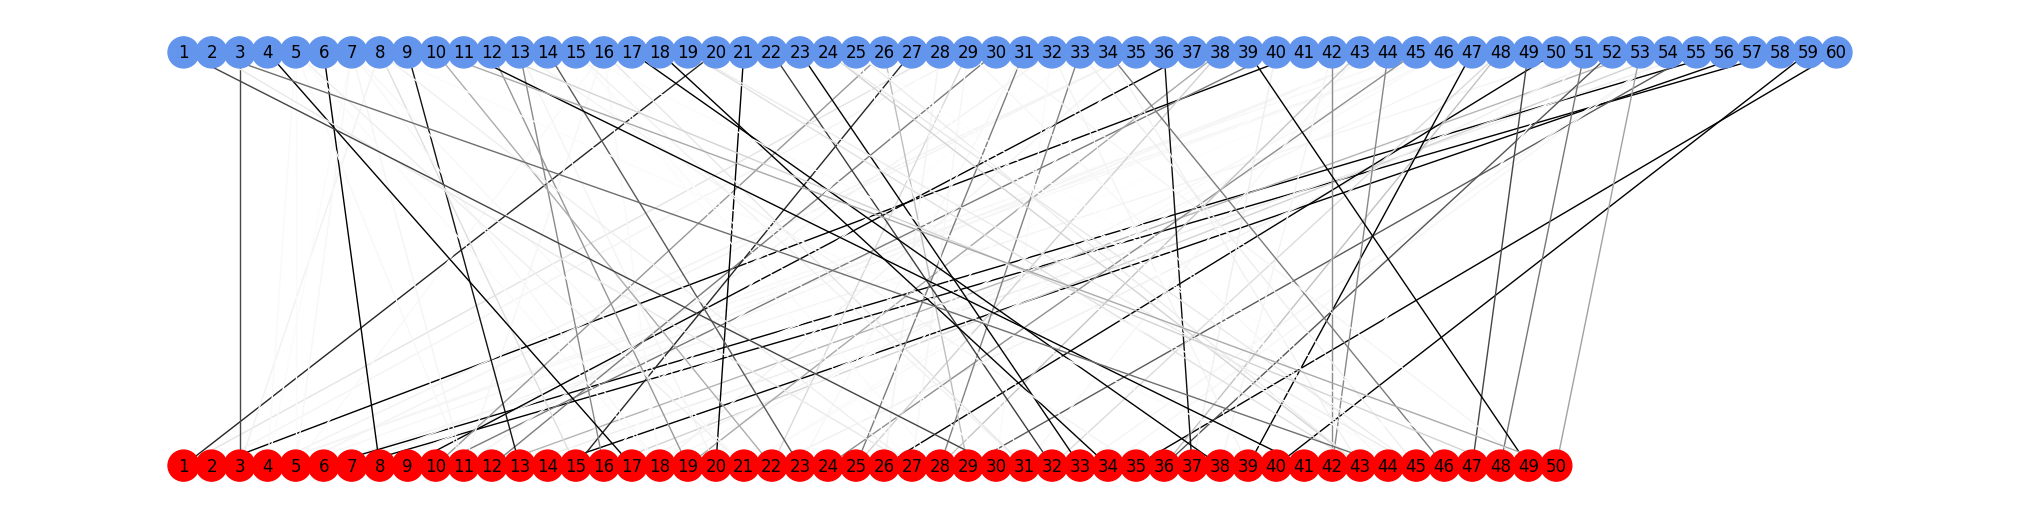

In [12]:
""" 
Create bipartite graph
"""

import networkx as nx
from networkx.algorithms import bipartite
import scipy.sparse as sparse

a_matrix = sparse.csc_matrix(coupling_thres)
edge_colors = []
for i in range(coupling_thres.shape[0]):
    for j in range(coupling_thres.shape[1]):
        if coupling_thres[i][j] != 0:
                edge_colors.append(coupling_thres[i][j])


G = bipartite.from_biadjacency_matrix(a_matrix, create_using=None, 
                                         edge_attribute='weight')
u = [n for n in G.nodes if G.nodes[n]['bipartite'] == 0]


X, Y = bipartite.sets(G, top_nodes=u)
labels = {}   
node_colors = [] 
for node in G.nodes:
    if node < coupling_thres.shape[0]:
        labels[node] = node+1
        node_colors.append('red')
    else:
        labels[node] = node+1-coupling_thres.shape[0]
        node_colors.append('cornflowerblue')

plt.figure(figsize=(20, 5))
pos = dict()
pos.update((n, (i*50, 0)) for i, n in enumerate(X))
pos.update((n, (i*50, 0.01)) for i, n in enumerate(Y))

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()

# nx.draw_networkx_edges(G, pos)
nx.draw(G, pos, labels=labels,
        edge_color=edge_colors, 
        edge_cmap=plt.get_cmap('Greys'),
        node_color=node_colors,
        node_size=500)
# nodes = nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)
# # Set edge color to red
# nodes.set_edgecolor('black')

fig_path = os.path.join(output_dir, "exp4_network.pdf")
plt.savefig(fig_path)
plt.show()

In [ ]:
# selected_df_female['count'] = counts
# plt.scatter(list(selected_df_female['count']), list(selected_df_female['ae_ratio']), s=4)

In [ ]:
heatmap_df 

In [ ]:
""" 
Run multiple iterations using Poisson regression
"""
score_path = os.path.join(output_dir, "exp4_poisson_score_"+str(n_components)+".csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, admid_diagnosis_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.PoissonRegressor, iteration=100)

In [ ]:
# score_path = os.path.join(output_dir, "exp4_poisson_score_"+str(n_components)+".csv")

# save_path = "../../outputs/mimic/exp4_poisson_res.png"
# box_plot_cts_short(score_path, save_path=save_path)


In [ ]:
""" 
Run multiple iterations using linear regression
"""
score_path = os.path.join(output_dir, "exp4_linear_score_"+str(n_components)+".csv")
male_count = 120
female_count = 100

multi_proc_cts(score_path, n_components, admid_diagnosis_df, custom_train_reps, \
    male_count, female_count, model_func = linear_model.LinearRegression, iteration=100)

In [ ]:
# score_path = os.path.join(output_dir, "exp4_linear_score.csv")
# save_path = "../../outputs/mimic/exp4_linear_res.png"

# box_plot_cts_short(score_path, save_path=save_path)

mae ratio using linear is: 0.7649548494940779
rmse ratio using linear is: 0.8643828397937844
mae ratio using poisson is: 0.8451120341533844
rmse ratio using poisson is: 0.9154057848628719
mae ratio to TCA using linear is: 0.8337621334316695
rmse ratio to TCA using linear is: 0.9037384005721683
mae ratio to TCA using poisson is: 0.755543446360696
rmse ratio to TCA using poisson is: 0.8536507917842849


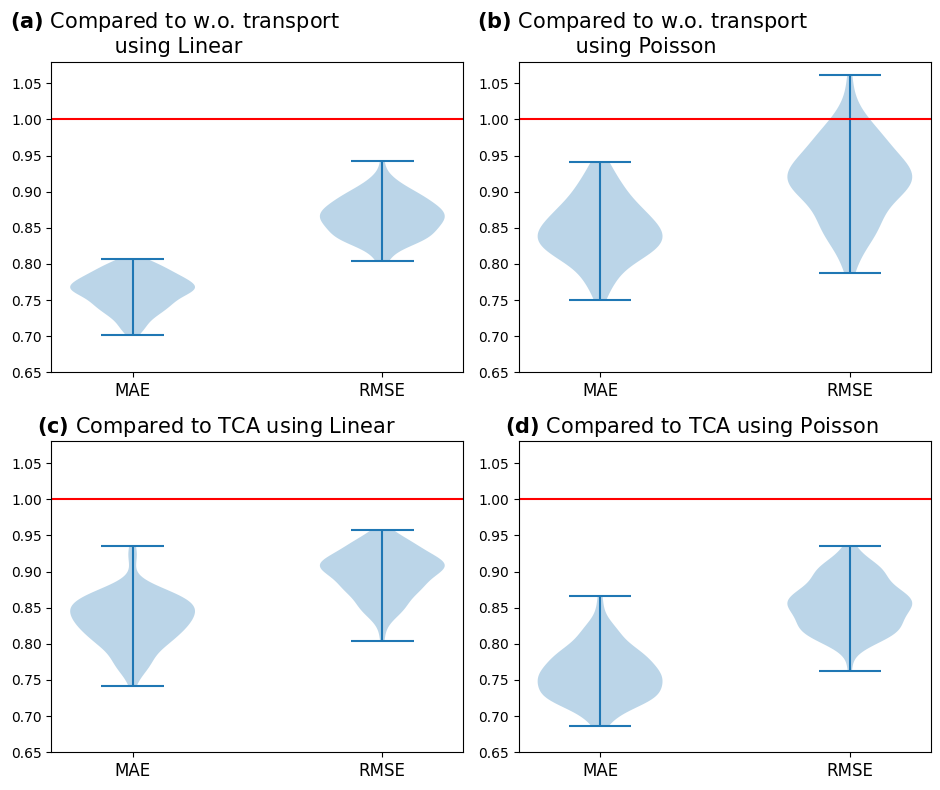

In [20]:
""" 
Combine plots for MIMIC experiment 4 together
"""
n_components = 50
def special_div(x, y):
    """ 
    Special division operation
    """
    if y == 0:
        y = 1e-5
    return x/y

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(9.5)
title_size = 15
text_size = 12
linear_score_path = os.path.join(output_dir, "exp4_linear_score_"+str(n_components)+".csv")

linear_scores_df = pd.read_csv(linear_score_path, index_col=None, header=0)

target_mae = linear_scores_df['target_mae']
target_rmse = linear_scores_df['target_rmse']

trans_target_mae = linear_scores_df['trans_target_mae']
trans_target_rmse = linear_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(trans_target_mae, target_mae)]
print("mae ratio using linear is:", median(trans_target_target_mae))
# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(trans_target_rmse, target_rmse)]
print("rmse ratio using linear is:", median(trans_target_target_rmse))


# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
axes[0][0].violinplot(data)

# Plot the baseline
axes[0][0].axhline(y = 1, color = 'r', linestyle = '-')
axes[0][0].set_xticks([1,2])
axes[0][0].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)
# ax.tick_params(labelsize=text_size)
axes[0][0].set_ylim(0.65, 1.08)
axes[0][0].set_title(r"$\bf{(a)}$ Compared to w.o. transport"+"\n using Linear", x=0.3, fontsize=title_size)


######################################################

poisson_score_path = os.path.join(output_dir, "exp4_poisson_score_"+str(n_components)+".csv")

poisson_scores_df = pd.read_csv(poisson_score_path, index_col=None, header=0)

target_mae = poisson_scores_df['target_mae']
target_rmse = poisson_scores_df['target_rmse']

trans_target_mae = poisson_scores_df['trans_target_mae']
trans_target_rmse = poisson_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(trans_target_mae, target_mae)]
print("mae ratio using poisson is:", median(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(trans_target_rmse, target_rmse)]
print("rmse ratio using poisson is:", median(trans_target_target_rmse))


# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
# ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[0][1])
axes[0][1].violinplot(data)


# Plot the baseline
axes[0][1].axhline(y = 1, color = 'r', linestyle = '-')
axes[0][1].set_xticks([1,2])
axes[0][1].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)

# ax.tick_params(labelsize=text_size)
axes[0][1].set_ylim(0.65, 1.08)
axes[0][1].set_title(r"$\bf{(b)}$ Compared to w.o. transport "+"\n using Poisson", x=0.3, fontsize=title_size)

#####################################################
tca_linear_score_path = os.path.join(output_dir, "exp4_tca_linear_score.csv")

tca_linear_scores_df = pd.read_csv(tca_linear_score_path, index_col=None, header=0)

ot_target_mae = linear_scores_df['trans_target_mae']
ot_target_rmse = linear_scores_df['trans_target_rmse']

tca_target_mae = tca_linear_scores_df['trans_target_mae']
tca_target_rmse = tca_linear_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(ot_target_mae, tca_target_mae)]
print("mae ratio to TCA using linear is:", median(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(ot_target_rmse, tca_target_rmse)]
print("rmse ratio to TCA using linear is:", median(trans_target_target_rmse))

# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
# ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[1][0])
axes[1][0].violinplot(data)
axes[1][0].set_xticks([1,2])
axes[1][0].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)

# Plot the baseline
axes[1][0].axhline(y = 1, color = 'r', linestyle = '-')

# ax.tick_params(labelsize=text_size)
axes[1][0].set_ylim(0.65, 1.08)
axes[1][0].set_title(r"$\bf{(c)}$ Compared to TCA using Linear", x=0.40, fontsize=title_size)


####################################################
tca_poisson_score_path = os.path.join(output_dir, "exp4_tca_poisson_score.csv")

tca_poisson_scores_df = pd.read_csv(tca_linear_score_path, index_col=None, header=0)

ot_target_mae = poisson_scores_df['trans_target_mae']
ot_target_rmse = poisson_scores_df['trans_target_rmse']

tca_target_mae = tca_poisson_scores_df['trans_target_mae']
tca_target_rmse = tca_poisson_scores_df['trans_target_rmse']

# transported source to source mae
trans_target_target_mae = [special_div(i, j) for i, j in zip(ot_target_mae, tca_target_mae)]
print("mae ratio to TCA using poisson is:", median(trans_target_target_mae))

# transported source to source rmse
trans_target_target_rmse = [special_div(i, j) for i, j in zip(ot_target_rmse, tca_target_rmse)]
print("rmse ratio to TCA using poisson is:", median(trans_target_target_rmse))

# Pandas dataframe
data = pd.DataFrame({
    'MAE ratio': trans_target_target_mae,
    'RMSE ratio': trans_target_target_rmse
})

# Plot the dataframe
# ax = data[['MAE ratio', 'RMSE ratio']].plot(kind='box', ax=axes[1][1])
axes[1][1].violinplot(data)


# Plot the baseline
axes[1][1].axhline(y = 1, color = 'r', linestyle = '-')
axes[1][1].set_xticks([1,2])
axes[1][1].set_xticklabels(['MAE', 'RMSE'], fontsize=text_size)

axes[1][1].set_ylim(0.65, 1.08)
axes[1][1].set_title(r"$\bf{(d)}$ Compared to TCA using Poisson", x=0.42, fontsize=title_size)
save_path = os.path.join(output_dir, "exp4_res.pdf")
plt.tight_layout()
plt.savefig(save_path, bbox_inches='tight')